MEDICINAL PLANTS CLASSIFICATION USING RESNET-9

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install torchsummary

In [2]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

Loading the data

In [11]:
from PIL import Image
import os

input_folder = "/content/drive/MyDrive/dataset/test/Raktachandini"
output_folder = "/content/drive/MyDrive/dataset/resized_test/Raktachandini"
target_size = (256, 256)
os.makedirs(output_folder, exist_ok=True)
for filename in os.listdir(input_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_folder, filename)
        img = Image.open(image_path)
        resized_img = img.resize(target_size, Image.ANTIALIAS)  # You can choose different resampling filters
        output_path = os.path.join(output_folder, filename)
        resized_img.save(output_path)

print("All images resized and saved to", output_folder)


<ipython-input-11-1fb40b6b6757>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(target_size, Image.ANTIALIAS)  # You can choose different resampling filters


All images resized and saved to /content/drive/MyDrive/dataset/resized_test/Raktachandini


In [12]:
data_dir = "/content/drive/MyDrive/dataset"
train_dir = data_dir + "/resized"
valid_dir = data_dir + "/resized_test"
plants = os.listdir(train_dir)

In [13]:
# printing the disease names
print(plants)

['Insulin', 'Raktachandini', 'Tulasi']


In [14]:
print("Total medicinal plants are: {}".format(len(plants)))

Total medicinal plants are: 3


In [15]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

`torchvision.datasets` is a class which helps in loading all common and famous datasets. It also helps in loading custom datasets. I have used subclass `torchvision.datasets.ImageFolder` which helps in loading the image data when the data is arranged in this way:

----------------
root/dog/xxx.png

root/dog/xxy.png

root/dog/xxz.png

<br>

root/cat/123.png

root/cat/nsdf3.png

root/cat/asd932_.png

----------------

Next, after loading the data, we need to transform the pixel values of each image (0-255) to 0-1 as neural networks works quite good with normalized data. The entire array of pixel values is converted to torch [tensor](https://pytorch.org/tutorials/beginner/examples_tensor/two_layer_net_tensor.html#:~:text=A%20PyTorch%20Tensor%20is%20basically,used%20for%20arbitrary%20numeric%20computation.) and then divided by 255.
If you are not familiar why normalizing inputs help neural network, read [this](https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d) post.

#### Image shape

In [16]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


We can see the shape (3, 256 256) of the image. 3 is the number of channels (RGB) and 256 x 256 is the width and height of the image

In [17]:
# total number of classes in train set
len(train.classes)

3

In [18]:
import pickle
with open('/content/drive/MyDrive/train_classes.pkl', 'wb') as file:
    pickle.dump(train.classes, file)

In [19]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Insulin(0)


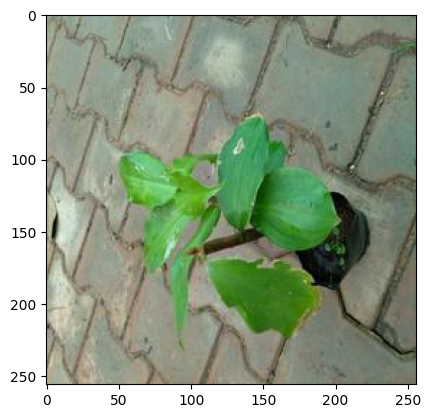

In [20]:
show_image(*train[0])

In [21]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [22]:
# setting the batch size
batch_size = 32

In [23]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [24]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


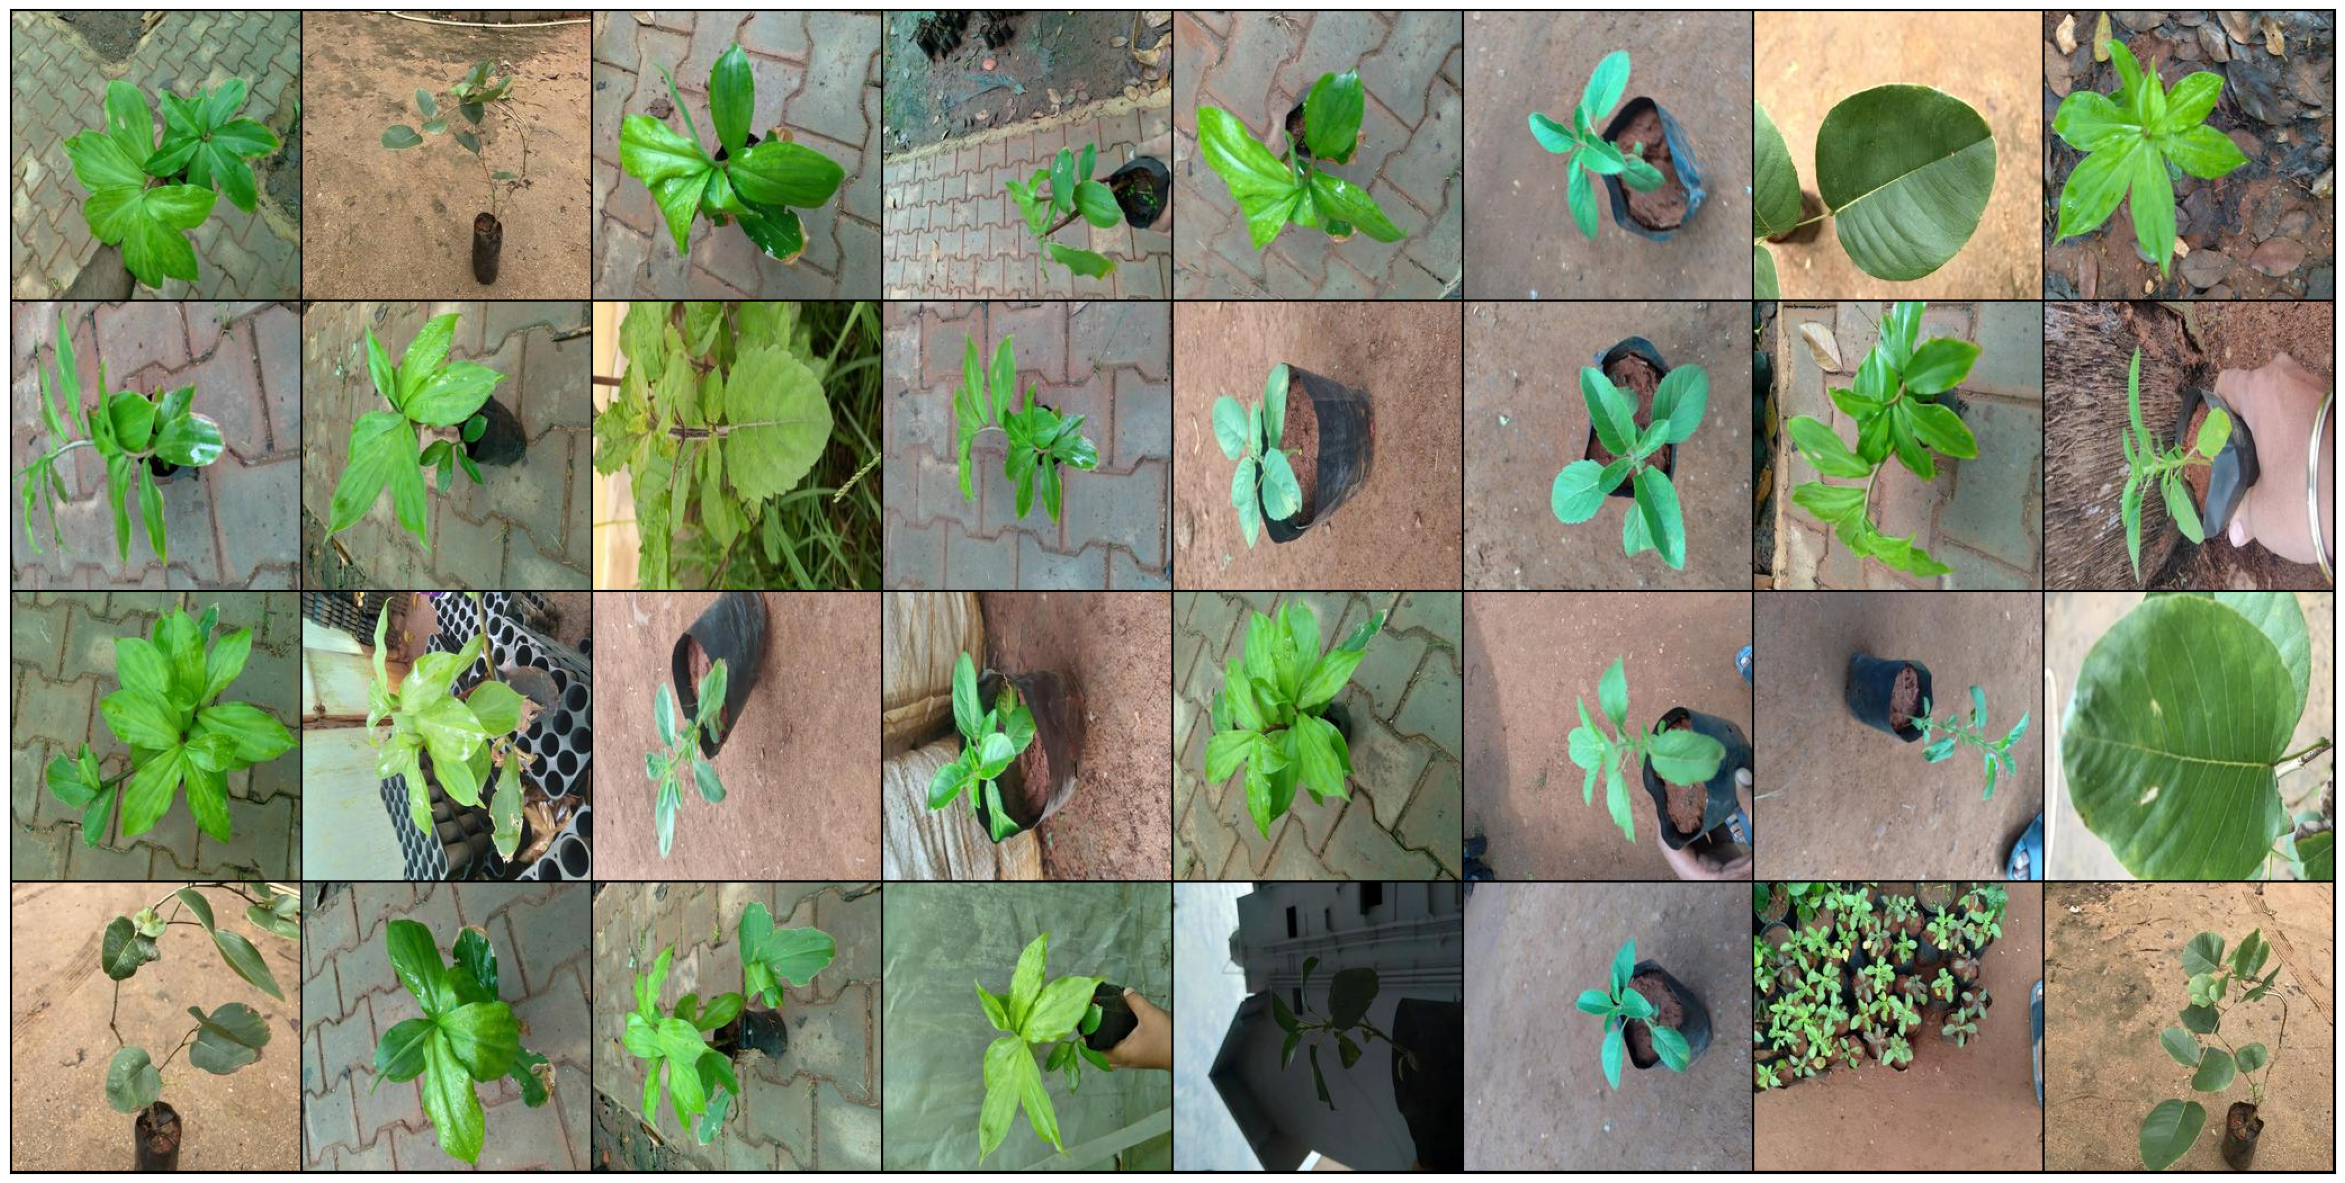

In [25]:
# Images for first batch of training
show_batch(train_dl)

In [26]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Checking the device we are working with

In [27]:
device = get_default_device()
device

device(type='cuda')

Wrap up our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available)

In [28]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Building the model

![image](https://www.mdpi.com/remotesensing/remotesensing-11-01896/article_deploy/html/images/remotesensing-11-01896-g001.png)

#### Residual Block code implementation

In [29]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [30]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


Defining the final architecture of our model

In [31]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [32]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

*Getting a nicely formatted summary of our model (like in Keras). Pytorch doesn't support it natively. So, we need to install the `torchsummary` library (discussed earlier)*

In [33]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [34]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


Let's check our validation loss and accuracy

In [35]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 426 ms, sys: 145 ms, total: 571 ms
Wall time: 1.03 s


[{'val_loss': tensor(1.1052, device='cuda:0'), 'val_accuracy': tensor(0.3021)}]

In [36]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [38]:
%%time
history += fit_OneCycle(50, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00049, train_loss: 0.2474, val_loss: 1.6201, val_acc: 0.4266
Epoch [1], last_lr: 0.00078, train_loss: 0.1259, val_loss: 0.8946, val_acc: 0.6091
Epoch [2], last_lr: 0.00127, train_loss: 0.1134, val_loss: 0.3355, val_acc: 0.8709
Epoch [3], last_lr: 0.00194, train_loss: 0.1524, val_loss: 0.5610, val_acc: 0.8030
Epoch [4], last_lr: 0.00275, train_loss: 0.2003, val_loss: 1.1629, val_acc: 0.7885
Epoch [5], last_lr: 0.00366, train_loss: 0.2152, val_loss: 0.3991, val_acc: 0.8650
Epoch [6], last_lr: 0.00465, train_loss: 0.1550, val_loss: 0.6396, val_acc: 0.8958
Epoch [7], last_lr: 0.00566, train_loss: 0.2007, val_loss: 1.1470, val_acc: 0.8134
Epoch [8], last_lr: 0.00665, train_loss: 0.2349, val_loss: 11.0219, val_acc: 0.6042
Epoch [9], last_lr: 0.00757, train_loss: 0.2454, val_loss: 1.2064, val_acc: 0.7844
Epoch [10], last_lr: 0.00839, train_loss: 0.2556, val_loss: 0.5304, val_acc: 0.8487
Epoch [11], last_lr: 0.00907, train_loss: 0.2476, val_loss: 4.3915, val_acc: 0.4896
E

In [39]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

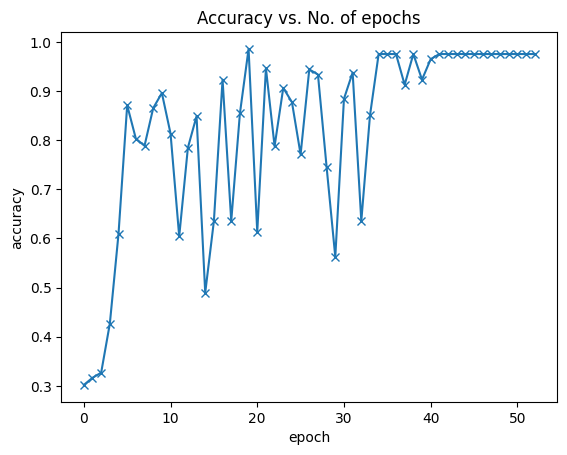

In [40]:
plot_accuracies(history)

In [41]:
# saving to the kaggle working directory
PATH = '/content/drive/MyDrive/medicine-plants-model.pth'
torch.save(model.state_dict(), PATH)